This cell imports necessary libraries such as pandas, seaborn, matplotlib, numpy, and scikit-learn modules for data manipulation, visualization, and machine learning. Additionally, it defines three functions:

preprocess_and_clean_data: Reads a CSV file, drops unnecessary columns, handles missing values, performs feature engineering, and returns preprocessed features and target variable.
select_features: Selects features using methods like "kbest" (SelectKBest) or "manual" based on user-defined criteria.
train_and_evaluate_model: Trains a regression model, makes predictions, and computes metrics like mean squared error, percent error, and r2 score.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Function to preprocess and clean data
def preprocess_and_clean_data(file_path):
    # Read the CSV file and drop unnecessary columns
    df = pd.read_csv(file_path)
    df = df.drop("ID", axis=1)
    
    # Drop rows with missing values
    df = df.dropna()

    # Separate features and target variable
    X = df.drop('mpg', axis=1)

    # Heatmap 
    EDA_df = df.copy()
    corr_matrix = EDA_df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
    plt.show()

    #Histogram
    EDA_df .hist(bins = 25, figsize = (15,10))

    # Feature engineering: adding a ratio and normalizing values
    X['displacement/cylinders'] = X['displacement'] / X['cylinders']
    scaler = preprocessing.MinMaxScaler()
    X_norm = pd.DataFrame(scaler.fit_transform(X), columns=[f"{x}_norm" for x in X.columns])
    X.reset_index(drop=True, inplace=True)
    X_norm.reset_index(drop=True, inplace=True)
    X = pd.concat([X, X_norm], axis=1)
    X = X.drop(['model_year_norm', 'origin_norm'], axis=1)

    # Log transformations for skewed distributions
    X[['log_weight', 'log_displacement', 'log_horsepower']] = np.log(X[['weight', 'displacement', 'horsepower']])

    # Return preprocessed features and target variable
    return X, df['mpg']



# Function to select features
def select_features(X, y, method, k):
    if method == "kbest":
        selector = SelectKBest(mutual_info_regression, k=k)
        selector.fit(X, y)
        return list(X.columns[selector.get_support()])
    elif method == "manual":
        return list(X.columns[:4])  # Manually selected features based on EDA

# Function to train and evaluate models
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, features):
    model.fit(X_train[features], y_train)
    pred = model.predict(X_test[features])
    mse = mean_squared_error(y_test, pred)
    percent_e = mean_absolute_percentage_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return {'mse': mse, 'percent_error': percent_e, 'r2': r2}


This cell loads the dataset from a CSV file, applies the preprocess_and_clean_data function, and defines different feature sets (feature_combos) for later use. Feature sets include original features, normalized features, k-best features with various k values, and manually selected features.

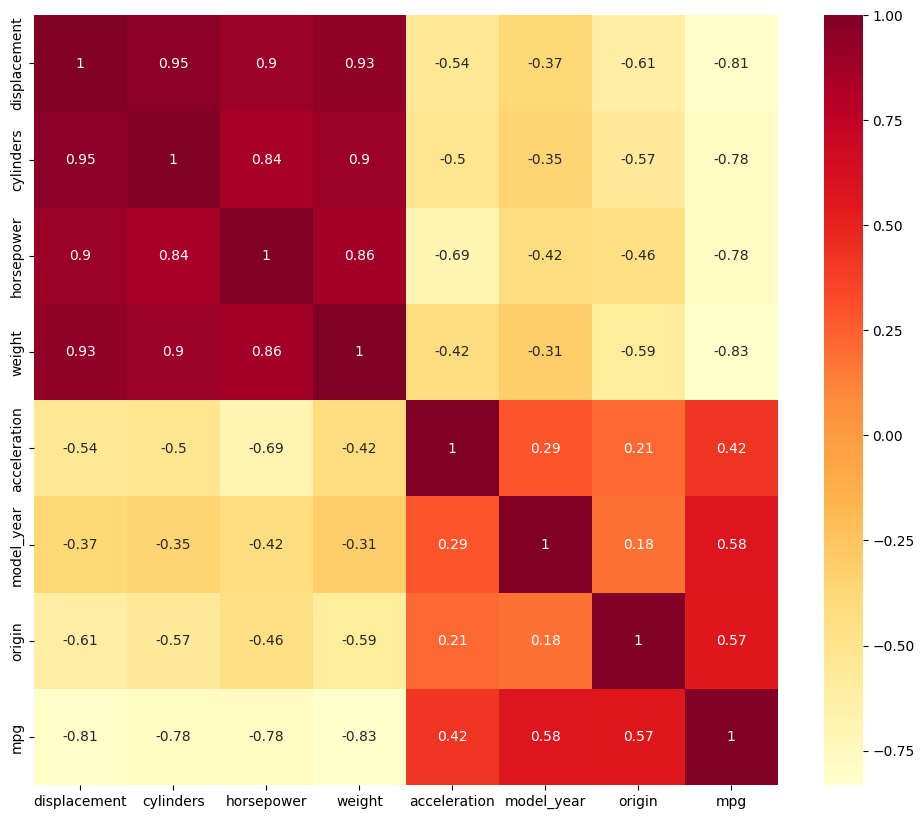

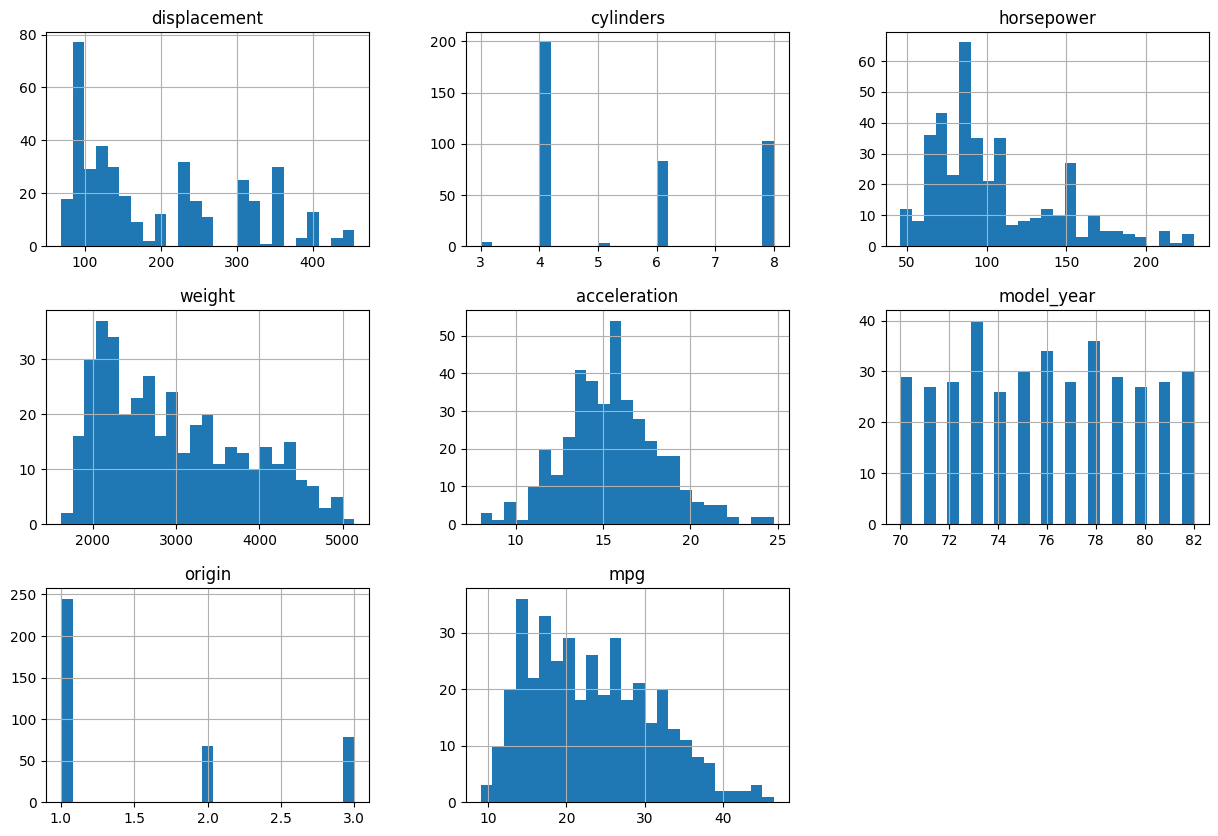

In [2]:

# Load data and preprocess
file_path = "auto_1993_adj.csv"
X, y = preprocess_and_clean_data(file_path)

# Define feature_combos
og_features = list(X.columns)
normalized = list(X.columns[X.columns.str.contains('_norm')])

# kbest filtering
selector = SelectKBest(mutual_info_regression, k=6)
selector.fit(X, y)
kbest = list(X.columns[selector.get_support()])

# kbest with diff k
selector = SelectKBest(mutual_info_regression, k=10)
selector.fit(X, y)
kbest_more = list(X.columns[selector.get_support()])

selector = SelectKBest(mutual_info_regression, k=3)
selector.fit(X, y)
kbest_less = list(X.columns[selector.get_support()])

manual = og_features[:4]

# Define feature_combos
feature_combos = [og_features, normalized, kbest, kbest_more, kbest_less, manual]

Here, the dataset is split into training and testing sets. The code then trains three regression models (KNeighborsRegressor, SVR, Ridge) using various feature sets. The resulting metrics are stored in the model_stats list for later analysis.

In [3]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99)

# Train and evaluate models
model_stats = []

for model in [KNeighborsRegressor(), SVR(), Ridge()]:
    for features in feature_combos:
        metrics = train_and_evaluate_model(model, X_train, X_test, y_train, y_test, features)
        model_stats.append({'model': str(model), 'features': features, **metrics})

model_stats_df = pd.DataFrame(model_stats)


This cell creates visualizations to compare the mean statistics of different regression models. Three subplots display percent error, r2 score, and mean squared error for each model type.

Text(0.5, 1.0, 'Mean Squared Error')

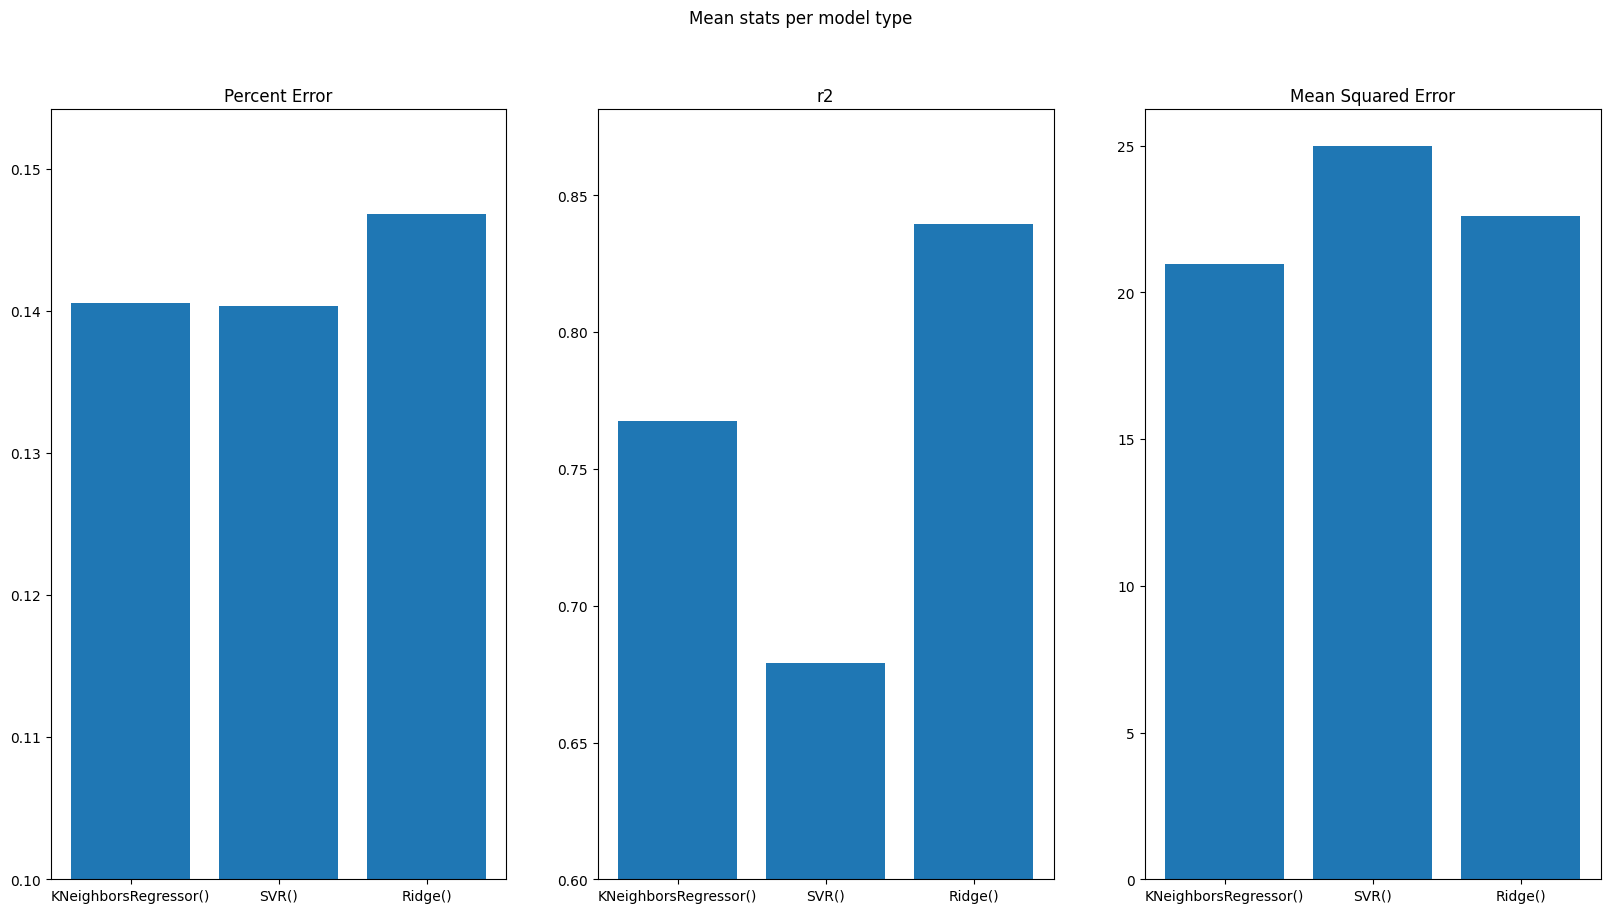

In [4]:
# Cell 4: Visualization of Model Performance

# Visualization of model performance
plt.figure(figsize=(20, 10))
plt.suptitle("Mean stats per model type")

plt.subplot(1, 3, 1)
plt.bar(model_stats_df['model'], model_stats_df['percent_error'])
plt.ylim(0.1)
plt.title("Percent Error")

plt.subplot(1, 3, 2)
plt.bar(model_stats_df['model'], model_stats_df['r2'])
plt.ylim(0.6)
plt.title("r2")

plt.subplot(1, 3, 3)
plt.bar(model_stats_df['model'], model_stats_df['mse'])
plt.title("Mean Squared Error")

The final cell focuses on visualizing the mean statistics for different feature sets. It explodes the feature lists in the model_stats DataFrame into individual rows and groups them by features and models. The resulting subplots show the mean percent error, r2 score, and mean squared error for each feature set.

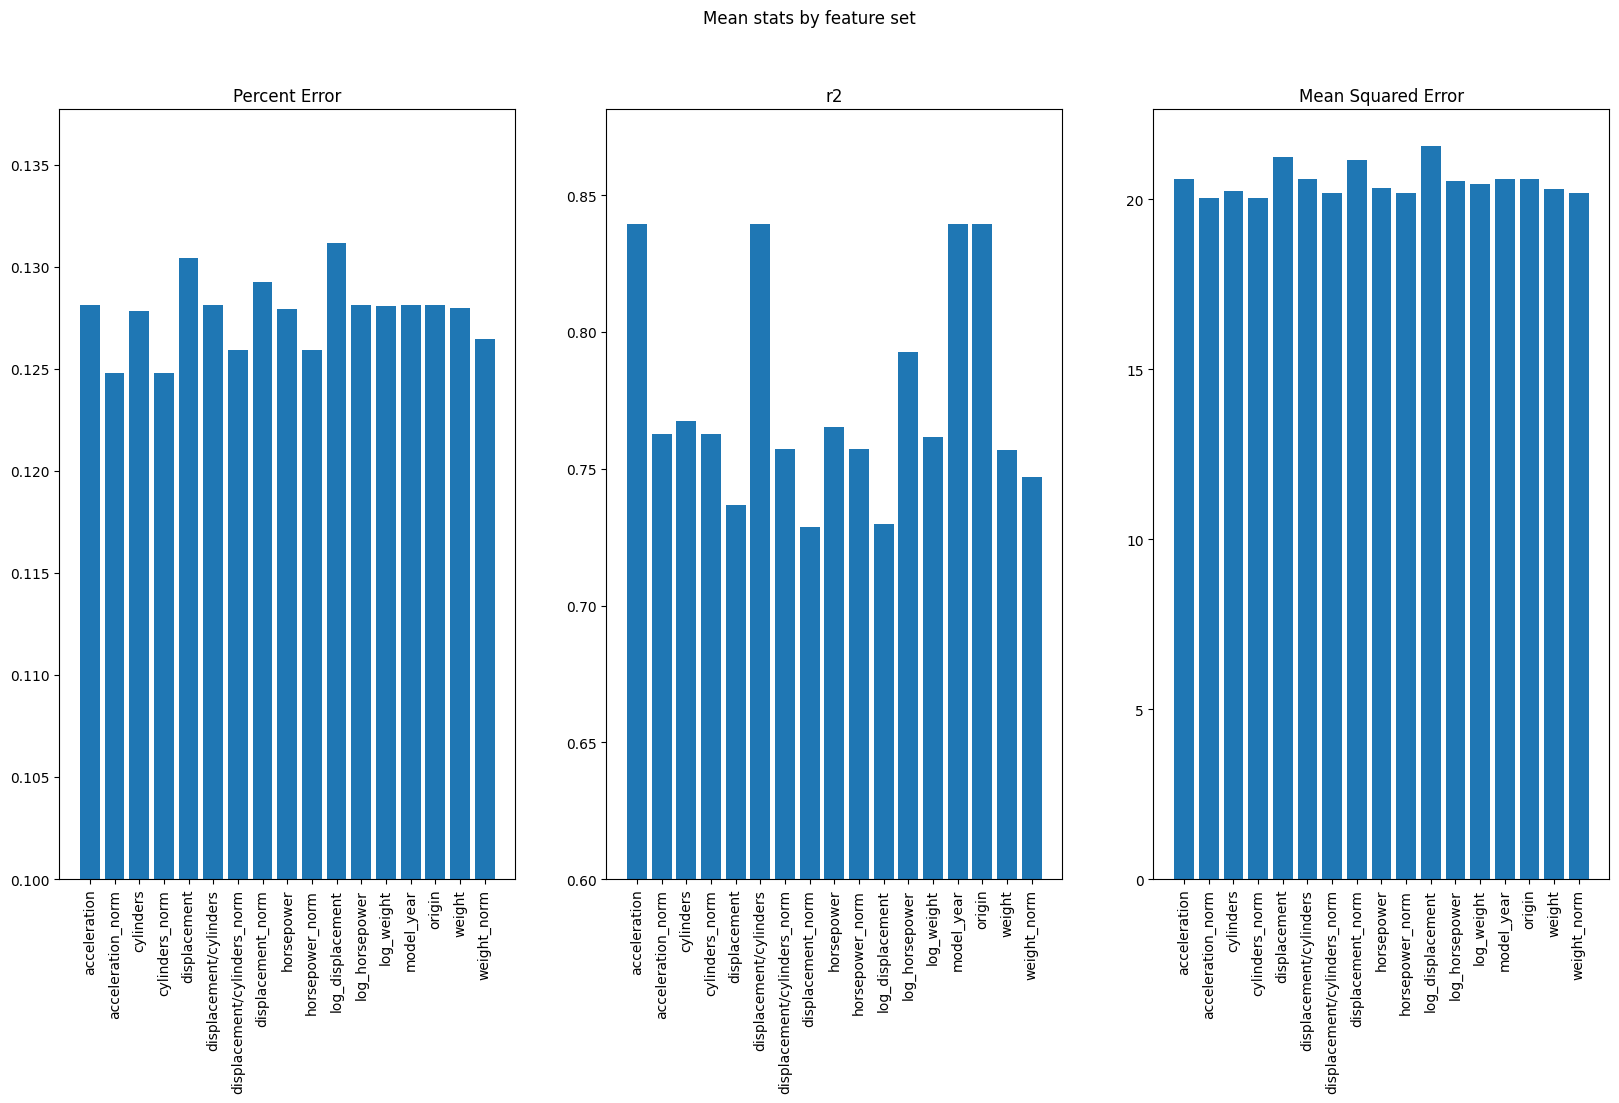

In [5]:
# Cell 5: Visualization of Feature Set Performance

# Visualization of feature set performance
test = model_stats_df.explode('features')  # Convert lists in 'features' column to individual rows
test = test.groupby(['features', 'model']).agg({'r2': 'mean', 'percent_error': 'mean', 'mse': 'mean'}).reset_index()

plt.figure(figsize=(20, 10))
plt.suptitle("Mean stats by feature set")

plt.subplot(1, 3, 1)
plt.bar(test['features'], test['percent_error'])
plt.ylim(0.1)
plt.title("Percent Error")
plt.xticks(rotation='vertical')

plt.subplot(1, 3, 2)
plt.bar(test['features'], test['r2'])
plt.ylim(0.6)
plt.title("r2")
plt.xticks(rotation='vertical')

plt.subplot(1, 3, 3)
plt.bar(test['features'], test['mse'])
plt.title("Mean Squared Error")
plt.xticks(rotation='vertical')

plt.show()
